# Start of actual analysis

Previous Paper: https://pubmed.ncbi.nlm.nih.gov/30334800/ 

used similar dataset, LSTM + 1d-AX + softmax

1d-AX: kinda like windowed mean in A2



Hybrid NN in time domain: https://www.biorxiv.org/content/10.1101/2020.09.20.305300v1.full

In [2]:
# import packages
import biosig
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.signal import butter, sosfiltfilt, sosfreqz 


import scipy.io
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Conv1D
from keras.optimizers import SGD, Nadam, Adam, RMSprop
from keras.metrics import Precision, Recall

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.decomposition import FastICA
from sklearn.metrics import confusion_matrix, classification_report

import mne
from mne.decoding import CSP
from mne import create_info

from tqdm import tqdm

In [25]:
# Define variables here
#Xuanyu
data_path = './BCICIV_2b_gdf/'#the folder where all raw data files live

#Can
#data_path = '/Users/canliu/COGS 189/Project'

train_portion = 0.7 #the portion of training data among all the raw data files

# from the data description document
event_start = 4 #the start time point (sec) of imagery for each trial
event_end = 7 #the end time point (sec) of imagery for each trial
bsl_start = 0 #the start time point (sec) of baseline for each trial
bsl_end = 2 #the end time point (sec) of baseline for each trial

files = [os.path.join(data_path, f) for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]
train_files = sorted([f for f in files if f[-7:-4] in ['01T', '02T']])
# for testing purposes only
#train_files = files[:5]

## Define functions

In [20]:
def time_ind_conversion(sr, t):
    """
    Convert time in second to the index in the signal array
    """
    return int(np.round(sr*t))


# from A1
def butter_bandpass(lowcut, highcut, fs, order = 2):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order = 2):
        sos = butter_bandpass(lowcut, highcut, fs, order = order)
        y = sosfiltfilt(sos, data)
        return y

def populate_filt_data(files, event_start, event_end, bsl_start, bsl_end, lowcut=7, highcut=30):
    """
    populate and pre-process data for training the model
    
    "It is noted in the literature that while performing any motor imagery tasks, 
    two major frequency band of EEG spectrum i.e mu (7-12 Hz) as well as beta (12-30 Hz) 
    bands are actively involved."
    
    input:
        files: list of file paths to the raw data files
        event_start: the start time point (sec) of imagery for each trial
        event_end: the end time point (sec) of imagery for each trial
        bsl_start: the start time point (sec) of baseline for each trial
        bsl_end: the end time point (sec) of baseline for each trial
        lowcut: lower end of the bandpass filter, default=7Hz
        highcut: higher end of the bandpass filter, default=30Hz
        
    output:
        data: list of eeg signal segments for each imagery 
        label: list of labels for each segment
    
    """
    labels = []
    data = []
    for i in files:
        HDR = json.loads(biosig.header(i))
        sr  = HDR['Samplingrate']
        events = pd.json_normalize(HDR['EVENT'])
        mi_events = events[events.Description.apply(lambda x: 'class' in x)]
        all_data = biosig.data(i).T
        
        for j in mi_events.index:
            t_start = time_ind_conversion(sr, events.POS[j-1]+event_start)
            t_end = time_ind_conversion(sr, events.POS[j-1]+event_end)
            #only use the EEG channels to prevent the model learning EOG patterns
            seg = all_data[:3, t_start:t_end]
            #calculate baseline and trial mean
            t_bsl_start = time_ind_conversion(sr, events.POS[j-1]+bsl_start)
            t_bsl_end = time_ind_conversion(sr, events.POS[j-1]+bsl_end)
            bsl_sig = all_data[:3, t_bsl_start:t_bsl_end]
            bsl = np.nanmean(bsl_sig, 1)
            trial_mean = np.nanmean(seg, 1)
            #preprocess the data by subtract baseline and the trial mean
            seg_after = butter_bandpass_filter((seg.T - bsl - trial_mean).T, lowcut=lowcut, highcut=highcut, fs=sr)
            if np.isnan(seg_after).sum()==0:
                data.append(seg_after)
                labels.append(mi_events.Description[j])
    return data, labels

def reshape_data(data, label):
    """
    reshape the data to the shape: n_samples * time * channels
    binarize the labels for the model
    """
    x = np.dstack(data)
    x = x.reshape(x.shape[2], x.shape[1], x.shape[0])
    lb = preprocessing.LabelBinarizer()
    y = lb.fit_transform(label)
    return x, y

def create_model(filters=256, pool_size=4, units=64, dropout=0.1, optim='adam'):
    model=Sequential()
    model.add(Conv1D(filters=filters, kernel_size=5, activation = 'relu', input_shape = (750, 3)))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    return model



## Build the model

### high pass + ICA (remove EOG) + CSP (augmentation)+ 1DConv(feature extraction) + LSTM (sequential learning)

In [50]:
# Load data after band-pass filter
train_data, train_label = populate_filt_data(train_files, event_start, event_end, bsl_start, bsl_end)
data, label = reshape_data(train_data, train_label)
train_x, test_x, train_y, test_y = train_test_split(data, label, test_size=0.2, random_state=42)

# TODO: Skip ICA for now because it didn't work

# CSP transformation
csp = CSP(rank={'eeg':3}, transform_into = 'csp_space')
x_new = csp.fit_transform(train_x.reshape(train_x.shape[0], train_x.shape[2], train_x.shape[1]), 
                          np.squeeze(train_y)).reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
x_new_test = csp.fit_transform(test_x.reshape(test_x.shape[0], test_x.shape[2], test_x.shape[1]),
                               np.squeeze(test_y)).reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2])

# plot top CSP filters here

In [51]:
# build model here
model = create_model()
model.fit(x_new, train_y, epochs=20, batch_size=50)
model.evaluate(x_new_test, test_y)

Epoch 1/20
36/36 [==============================] - 28s 716ms/step - loss: 0.6941 - accuracy: 0.5436
Epoch 2/20
36/36 [==============================] - 26s 711ms/step - loss: 0.6925 - accuracy: 0.5205
Epoch 3/20
36/36 [==============================] - 25s 684ms/step - loss: 0.6849 - accuracy: 0.5338
Epoch 4/20
36/36 [==============================] - 25s 703ms/step - loss: 0.6772 - accuracy: 0.5660
Epoch 5/20
36/36 [==============================] - 27s 743ms/step - loss: 0.6697 - accuracy: 0.5971
Epoch 6/20
36/36 [==============================] - 25s 694ms/step - loss: 0.6677 - accuracy: 0.5907
Epoch 7/20
36/36 [==============================] - 25s 688ms/step - loss: 0.6520 - accuracy: 0.6202
Epoch 8/20
36/36 [==============================] - 25s 688ms/step - loss: 0.6626 - accuracy: 0.6026
Epoch 9/20
36/36 [==============================] - 25s 686ms/step - loss: 0.6429 - accuracy: 0.6113
Epoch 10/20
36/36 [==============================] - 25s 688ms/step - loss: 0.6296 - accura

[0.8942028880119324, 0.5055928230285645]

/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[Text(33.0, 0.5, 'Predicted'), Text(0.5, 15.0, 'Actual')]

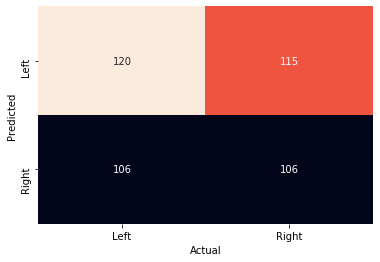

In [52]:
y_pred = model.predict_classes(x_new_test)
cm = confusion_matrix(test_y, np.rint(y_pred))
ax = sn.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=['Left', 'Right'], yticklabels=['Left', 'Right'])
ax.set(xlabel='Actual', ylabel='Predicted')

In [53]:
print(classification_report(test_y, np.rint(y_pred)))

              precision    recall  f1-score   support

           0       0.53      0.51      0.52       235
           1       0.48      0.50      0.49       212

    accuracy                           0.51       447
   macro avg       0.51      0.51      0.51       447
weighted avg       0.51      0.51      0.51       447



### Train on each individual

In [59]:
def training_pipeline(train_data, train_label, verbose=1):
    data, label = reshape_data(train_data, train_label)
    train_x, test_x, train_y, test_y = train_test_split(data, label, test_size=0.3, random_state=42)

    # TODO: Skip ICA for now because it didn't work

    # CSP transformation
    csp = CSP(rank={'eeg':3}, transform_into = 'csp_space')
    x_new = csp.fit_transform(train_x.reshape(train_x.shape[0], train_x.shape[2], train_x.shape[1]), 
                              np.squeeze(train_y)).reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
    x_new_test = csp.fit_transform(test_x.reshape(test_x.shape[0], test_x.shape[2], test_x.shape[1]),
                                   np.squeeze(test_y)).reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2])
    model = create_model()
    model.fit(x_new, train_y, epochs=10, batch_size=20, verbose=verbose)
    y_pred = model.predict_classes(x_new_test)
    eval_result = classification_report(test_y, np.rint(y_pred), output_dict=True)
    return eval_result


In [60]:
results = []
mne.set_log_level('warning')
for i in tqdm(range(int(len(train_files)/2))):
    print('Training sample #%d'%i)
    indiv_train = [train_files[i*2], train_files[i*2+1]]
    train_data, train_label = populate_filt_data(indiv_train, event_start, event_end, bsl_start, bsl_end)
    eval_result = training_pipeline(train_data, train_label, verbose=0)
    results.append(eval_result)

  0%|          | 0/9 [00:00<?, ?it/s]

Training sample #0


 11%|█         | 1/9 [00:45<06:02, 45.29s/it]

Training sample #1


 22%|██▏       | 2/9 [01:30<05:16, 45.22s/it]

Training sample #2


 33%|███▎      | 3/9 [02:15<04:31, 45.20s/it]

Training sample #3


 44%|████▍     | 4/9 [02:53<03:35, 43.14s/it]

Training sample #4


 56%|█████▌    | 5/9 [03:42<02:59, 44.93s/it]

Training sample #5


 67%|██████▋   | 6/9 [04:27<02:14, 44.83s/it]

Training sample #6


 78%|███████▊  | 7/9 [05:12<01:29, 44.99s/it]

Training sample #7


 89%|████████▉ | 8/9 [06:03<00:46, 46.75s/it]

Training sample #8


100%|██████████| 9/9 [06:48<00:00, 45.43s/it]


In [64]:
results

[{'0': {'precision': 0.5833333333333334,
   'recall': 0.34146341463414637,
   'f1-score': 0.43076923076923085,
   'support': 41},
  '1': {'precision': 0.4375,
   'recall': 0.6774193548387096,
   'f1-score': 0.5316455696202531,
   'support': 31},
  'accuracy': 0.4861111111111111,
  'macro avg': {'precision': 0.5104166666666667,
   'recall': 0.509441384736428,
   'f1-score': 0.48120740019474195,
   'support': 72},
  'weighted avg': {'precision': 0.5205439814814815,
   'recall': 0.4861111111111111,
   'f1-score': 0.4742020988856432,
   'support': 72}},
 {'0': {'precision': 0.5757575757575758,
   'recall': 0.5,
   'f1-score': 0.5352112676056339,
   'support': 38},
  '1': {'precision': 0.5128205128205128,
   'recall': 0.5882352941176471,
   'f1-score': 0.547945205479452,
   'support': 34},
  'accuracy': 0.5416666666666666,
  'macro avg': {'precision': 0.5442890442890442,
   'recall': 0.5441176470588236,
   'f1-score': 0.541578236542543,
   'support': 72},
  'weighted avg': {'precision': 0.5

In [67]:
all_avg_precision_lstm = [x['weighted avg']['precision'] for x in results]
all_avg_recall_lstm = [x['weighted avg']['recall'] for x in results]
all_accuracy_lstm = [x['accuracy']for x in results]

In [68]:
all_accuracy_lstm

[0.4861111111111111,
 0.5416666666666666,
 0.5,
 0.5256410256410257,
 0.5128205128205128,
 0.5138888888888888,
 0.5277777777777778,
 0.47619047619047616,
 0.4444444444444444]

In [69]:
print('mean precision = %f'%np.mean(all_avg_precision_lstm))
print('mean recall = %f'%np.mean(all_avg_recall_lstm))
print('mean accuracy = %f'%np.mean(all_accuracy_lstm))

mean precision = 0.512837
mean recall = 0.503171
mean accuracy = 0.503171


In [80]:
print('std precision = %f'%np.std(all_avg_precision_lstm))
print('std recall = %f'%np.std(all_avg_recall_lstm))
print('std accuracy = %f'%np.std(all_accuracy_lstm))

std precision = 0.031289
std recall = 0.028437
std accuracy = 0.028437


## CSP-LDA baseline model

In [73]:
train_data, train_label = populate_filt_data(train_files, event_start, event_end, bsl_start, bsl_end)
data, label = reshape_data(train_data, train_label)
train_x, test_x, train_y, test_y = train_test_split(data, label, test_size=0.2, random_state=42)
csp = CSP(n_components=4, rank={'eeg':3})
x_new = csp.fit_transform(train_x.reshape(train_x.shape[0], train_x.shape[2], train_x.shape[1]), 
                          np.squeeze(train_y))
x_new_test = csp.fit_transform(test_x.reshape(test_x.shape[0], test_x.shape[2], test_x.shape[1]),
                               np.squeeze(test_y))
lda = LinearDiscriminantAnalysis(solver = 'lsqr')
lda.fit(x_new, train_y)
lda.score(x_new_test, test_y)

/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4988814317673378

[Text(33.0, 0.5, 'Predicted'), Text(0.5, 15.0, 'Actual')]

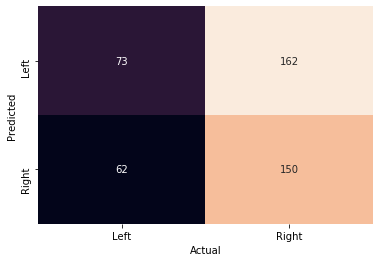

In [74]:
y_pred = lda.predict(x_new_test)
cm = confusion_matrix(test_y, np.rint(y_pred))
ax = sn.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=['Left', 'Right'], yticklabels=['Left', 'Right'])
ax.set(xlabel='Actual', ylabel='Predicted')

In [75]:
print(classification_report(test_y, np.rint(y_pred)))

              precision    recall  f1-score   support

           0       0.54      0.31      0.39       235
           1       0.48      0.71      0.57       212

    accuracy                           0.50       447
   macro avg       0.51      0.51      0.48       447
weighted avg       0.51      0.50      0.48       447



### On each individual

In [76]:
def csp_lda_pipeline(train_data, train_label):
    data, label = reshape_data(train_data, train_label)
    train_x, test_x, train_y, test_y = train_test_split(data, label, test_size=0.3, random_state=42)

    csp = CSP(n_components=4, rank={'eeg':3})
    x_new = csp.fit_transform(train_x.reshape(train_x.shape[0], train_x.shape[2], train_x.shape[1]), 
                              np.squeeze(train_y))
    x_new_test = csp.fit_transform(test_x.reshape(test_x.shape[0], test_x.shape[2], test_x.shape[1]),
                                   np.squeeze(test_y))
    lda = LinearDiscriminantAnalysis(solver = 'lsqr')
    lda.fit(x_new, train_y)
    print(lda.score(x_new_test, test_y))

    y_pred = lda.predict(x_new_test)
    eval_result = classification_report(test_y, np.rint(y_pred), output_dict=True)
    return eval_result

In [78]:
results = []
mne.set_log_level('warning')
for i in tqdm(range(int(len(train_files)/2))):
    print('Training sample #%d'%i)
    train_data, train_label = populate_filt_data([train_files[i*2], train_files[i*2+1]], event_start, event_end, bsl_start, bsl_end)
    eval_result = csp_lda_pipeline(train_data, train_label)
    results.append(eval_result)
all_avg_precision_lda = [x['weighted avg']['precision'] for x in results]
all_avg_recall_lda = [x['weighted avg']['recall'] for x in results]
all_accuracy_lda = [x['accuracy']for x in results]

  0%|          | 0/9 [00:00<?, ?it/s]

Training sample #0


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 11%|█         | 1/9 [00:00<00:07,  1.01it/s]

0.4444444444444444
Training sample #1


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 22%|██▏       | 2/9 [00:01<00:06,  1.01it/s]

0.5277777777777778
Training sample #2


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 33%|███▎      | 3/9 [00:02<00:05,  1.01it/s]

0.4722222222222222
Training sample #3


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 44%|████▍     | 4/9 [00:03<00:04,  1.02it/s]

0.5769230769230769
Training sample #4


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 56%|█████▌    | 5/9 [00:04<00:03,  1.03it/s]

0.41025641025641024
Training sample #5


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 67%|██████▋   | 6/9 [00:05<00:02,  1.07it/s]

0.4166666666666667
Training sample #6


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 78%|███████▊  | 7/9 [00:06<00:01,  1.02it/s]

0.4027777777777778
Training sample #7


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 89%|████████▉ | 8/9 [00:08<00:01,  1.06s/it]

0.5476190476190477
Training sample #8


/Users/xuanyuwu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|██████████| 9/9 [00:08<00:00,  1.01it/s]

0.5833333333333334


In [79]:
print('mean precision = %f'%np.mean(all_avg_precision_lda))
print('mean recall = %f'%np.mean(all_avg_recall_lda))
print('mean accuracy = %f'%np.mean(all_accuracy_lda))

mean precision = 0.494200
mean recall = 0.486891
mean accuracy = 0.486891


In [81]:
print('std precision = %f'%np.std(all_avg_precision_lda))
print('std recall = %f'%np.std(all_avg_recall_lda))
print('std accuracy = %f'%np.std(all_accuracy_lda))

std precision = 0.067056
std recall = 0.068850
std accuracy = 0.068850


In [92]:
indiv_accuracy = pd.DataFrame( {'Our model': all_accuracy_lstm, 'LDA':all_accuracy_lda})
indiv_accuracy.index.name = 'Subject ID'
indiv_accuracy

,Our model,LDA
Subject ID,,
0,0.486111,0.444444
1,0.541667,0.527778
2,0.500000,0.472222
3,0.525641,0.576923
4,0.512821,0.410256
5,0.513889,0.416667
6,0.527778,0.402778
7,0.476190,0.547619
8,0.444444,0.583333


# Questions for check point 1

1. Remove EOG artifact: Needed? How?
    
2. Another tangent: feasible to include EOG information in the classification? Individual variation too high?
    
3. CSP? Restricted by the number of channels?
    
4. Difference not distinct between averaged signals
    
5. Amplitude much smaller after averaging, also noisier
    
6. preprocesing data: does order matter (DC offset -> filtfilt -> baseline correct); what else needed?


compute C3-C4, C4-C3, or diff with Cz, then bandpass 7-30Hz
take the log of the power (normally distributed)

diff more distinct in freq space

EOG artifact:

ICA (http://www.cogsci.ucsd.edu/academicPubs/igorodni/eog-filtering.pdf)

subtract EOG from EEG? **find code**

## Questions for check point 2

1. accuracy not good... problem with approach?
2. data augmentation? 
    
    "deep convolutional generative adversarial network (DCGAN) provided better augmentation performance than traditional DA methods: geometric transformation (GT), autoencoder (AE), and variational autoencoder (VAE)"
    
    Is CSP a kind of data augmentation? no, but generate better features
    
    Worth trying? time domain: high pass + ICA (remove EOG) + CSP (augmentation)+ 1DConv + max pooling (feature extraction) + LSTM (sequential learning)
    
    try CSP with top 3 filters

Try on 64 channel set

Run model only on EOG to make sure the model is not using eye moving data

Try train on individual data